# SAS 해커톤에 쓰일 dummy data maker

In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=10)
from faker import Faker
fake_ko = Faker('ko_KR')

import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from collections import defaultdict

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# 폰트 설정
from matplotlib import font_manager, rc
font_name = "Malgun Gothic"  # 나눔고딕 폰트 이름 (이미 설치되어 있다고 가정)

rc('font', family=font_name)
# 그래프에 마이너스 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False



In [3]:
# 데이터는 총 num_samples 개
## 수급자
num_samples = 100007
## 부당비율 3% 가정
fraud_ratio = int(0.03 * num_samples)
## 종사자

## 기관


#### get data

In [4]:
## 주소 index 생성
address = pd.read_csv('./gps_data/merged_output.csv')

prs = pd.read_csv('./prs_dummy_data.csv')

with open('gps_noise.pkl', 'rb') as f:
    noise = pickle.load(f)


In [5]:
prs

,Unnamed: 0,ID,LTC_ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_X,GPS_BASE_Y
0,0,L160034205,3-86247-00028,김너주,3,1934-04-07,강원특별자치도,135415,128.023627,37.721240
1,1,L110018660,2-86247-00111,이터빌,3,1944-03-23,강원특별자치도,200593,128.020061,38.176570
2,2,L090088482,3-86247-00207,박돌보,3,1940-01-10,강원특별자치도,536,127.674917,37.838683
3,3,L210048725,3-86247-00034,류조산,5,1932-06-28,강원특별자치도,187512,127.404210,38.277389
4,4,L210051942,3-86247-00186,서춤논,4,1946-05-03,강원특별자치도,179318,128.702571,37.470652
...,...,...,...,...,...,...,...,...,...,...
99995,99995,L130031750,2-15591-00046,김놀펄,4,1951-05-24,충청북도,3554944,127.537532,36.659409
99996,99996,L180014004,2-11674-00561,최딩비,5,1945-05-31,충청북도,3645986,127.590550,36.973971
99997,99997,L080074648,3-15591-00056,김처두,1,1941-07-08,충청북도,3602226,128.205037,37.097820
99998,99998,L180046596,2-15591-00070,이훈시,5,1939-05-11,충청북도,3574815,127.834434,36.947349


In [8]:
noise, noise.shape

(array([[[-4.14880149e-01,  1.29277168e-01],
         [-1.78046201e+00, -1.26020680e+00],
         [-1.14522807e+00,  1.59624824e+00],
         ...,
         [ 6.55309577e-02, -1.13681076e+00],
         [ 4.42690318e-01, -9.89969314e-01],
         [-7.92164836e-01,  1.06009953e+00]],
 
        [[-3.66023026e-01, -5.79066179e-01],
         [-5.12975506e-02, -3.53199700e-01],
         [ 9.99005987e-01, -7.45344775e-01],
         ...,
         [-2.53314315e-01,  7.73822808e-01],
         [ 2.54950270e-01, -5.94807082e-02],
         [ 6.78422320e-01,  1.15935632e+00]],
 
        [[ 9.89946284e-01, -2.85641745e+00],
         [ 2.21110946e-01,  2.65934251e-01],
         [-6.81751542e-03, -1.90115266e-01],
         ...,
         [ 8.77276046e-01, -3.03161371e-01],
         [ 3.37085740e-01,  2.67189158e+00],
         [ 1.87710082e+00,  2.35469883e+00]],
 
        ...,
 
        [[ 6.71060273e-02, -4.55045979e-01],
         [-2.04121116e+00, -2.34873536e-01],
         [-5.55465015e-01,  9.9821

In [9]:
# 위도, 경도에 미터당 차이
lat_per_meter = 0.0000449  # 1m 당 위도 차이
lon_per_meter = 0.0000563  # 서울 기준 1m 당 경도 차이

lat_per_50m = lat_per_meter * 50  # 1m 당 위도 차이
lon_per_50m = lon_per_meter * 50 # 서울 기준 1m 당 경도 차이
#50m 이내의 gps noise, 전체에 대해서 100개씩 생성해보기.
#1을 50m로 설정.

In [12]:
# Calculate the noise in terms of GPS coordinates with proper scaling for latitude and longitude
gps_noise_x_adjusted = noise[:, :, 0] * lon_per_50m  # For longitude
gps_noise_y_adjusted = noise[:, :, 1] * lat_per_50m  # For latitude

# Generate noisy GPS data by adding the scaled noise to the base GPS coordinates
gps_x_adjusted = prs['GPS_BASE_X'].values[:, None] + gps_noise_x_adjusted
gps_y_adjusted = prs['GPS_BASE_Y'].values[:, None] + gps_noise_y_adjusted

# Create a DataFrame for the adjusted noisy GPS data
gps_data = pd.DataFrame({
    'ID': np.repeat(prs['ID'].values, gps_x_adjusted.shape[1]),
    'gps_x': gps_x_adjusted.flatten(),
    'gps_y': gps_y_adjusted.flatten()
})

In [13]:
gps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ID      object 
 1   gps_x   float64
 2   gps_y   float64
dtypes: float64(2), object(1)
memory usage: 228.9+ MB


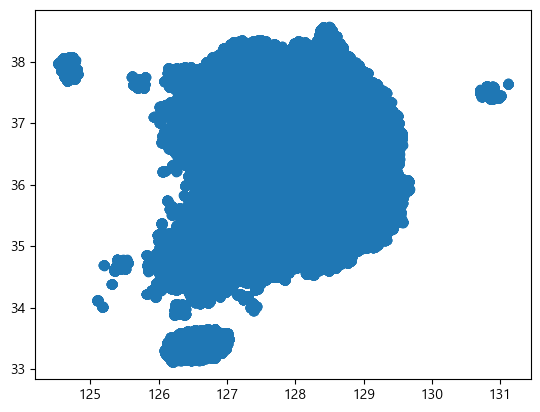

In [15]:
plt.scatter(gps_data.gps_x, gps_data.gps_y)

In [17]:
gps_data.to_csv('gps_dummy_data.csv')